<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/Exercise1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1b

Team members:

*   Rudolf Braun 
*   Jannik Schacht
*   Kieran Didi


## 1. Nearest Neighbor Classification on Real Data

In [60]:
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
import timeit

## 1.1 Exploring the Data 

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64
nearest interpolation:


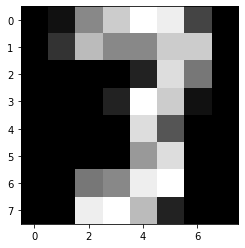

bicubic interpolation:


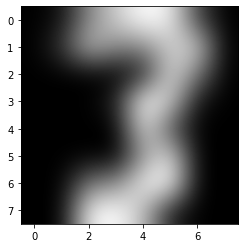

In [34]:
digits = load_digits ()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

img = images[23]
assert 2 == len(img.shape)
plt.figure()
plt.gray()

# use interpolation "nearest"
print("nearest interpolation:")
plt.imshow(img , interpolation="nearest")
plt.show()

# use interpolation "bicubic"
print("bicubic interpolation:")
plt.imshow(img , interpolation="bicubic")
plt.show()

def split_data(data, target):
  X_train , X_test , y_train , y_test =\
  model_selection.train_test_split(data, target, test_size = 0.4, random_state = 0)
  return X_train , X_test , y_train , y_test

The shape of the images in "digits["images"]" is (8,8), but the shapes of the images of the testing and training sets "X_test" and "X_train" are (64).

## 1.2 Distance function computation using loops

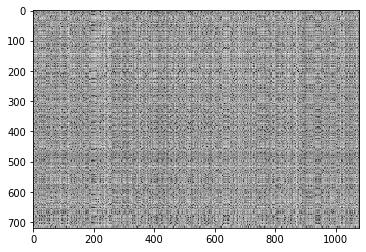

In [65]:
# helper function to measure the distance between two flattened images img1,img2 using a loop
def dist_loop_helper(img1, img2):
    diffsquared = 0             # diffsquared is the sum of the differences squared
    for i in range(len(img1)):  # loop over all pixels
        diffsquared += (img1[i]-img2[i])**2
    return np.sqrt(diffsquared)

# function that takes two sets "train" and "test" and returns the distances between every combination of two members of both sets.
# the distances are measured by the loop-distancefunction
def dist_loop(train, test):
    distances = [
        [
            dist_loop_helper(train[i],test[j]) for i in range(len(train))
        ] for j in range(len(test))
    ]
    return np.array(distances)

# create training and test set
X_train , X_test , y_train , y_test = split_data(data, target)

# calculate distance matrix using implementation with loops
dist_matrix_loop = dist_loop(X_train, X_test)

# display distance matrix as a grayscale image
plt.figure()
plt.gray()
plt.imshow(dist_matrix_loop , interpolation="nearest")
plt.show()

## 1.3 Distance function computation using vectorization

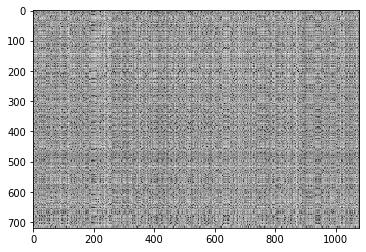

In [72]:
# function measuring the distances between two sets of images, vectorized
def dist_vec(training, test):
    ltrain = len(training) # length of the training set
    ltest = len(test) # length of the test set
    # for further calculations two arrays are created, one with ltrain times the test images, one with ltest times the train images
    # -> so both arrays contain the same number of entries in total
    # to copy the entries the arrays are converted into a list and than back to an array
    trainarr = np.array(training.tolist()*ltest).reshape(ltest,ltrain,64)
    testarr = np.array(test.tolist()*ltrain).reshape(ltrain,ltest,64)
    # to calculate the differences of the arrays both arrays have to have the same shape 
    # -> the axes are reanranged.
    # to sum the squared differences later it is convenient to put the last axis in front
    trainarr_reshaped = np.transpose(trainarr, [2,0,1])
    testarr_reshaped = np.transpose(testarr, [2,1,0])
    # now the differnces can be calculated and converted into "distances" using pythagoras
    imgdist = np.sqrt(sum(np.square(trainarr_reshaped-testarr_reshaped)))
    return imgdist

# calculate distance matrix using implementation with vectorization
dist_matrix_vec = dist_vec(X_train, X_test)

# display distance matrix as a grayscale image
plt.figure()
plt.gray()
plt.imshow(dist_matrix_vec , interpolation="nearest")
plt.show()

In [68]:
# verify that both distance matrices are equal
compare = dist_matrix_loop == dist_matrix_vec
equal = compare.all()
print("Both distance matrices are equal:", equal)

Both distance matrices are equal: True


In [ ]:
# time measurements
print("Distance function using loops:")
%timeit -n 3 -r 1 dist_loop(X_train, X_test)

print("Distance function using vectorization:")
%timeit -n 3 -r 1 dist_vec(X_train, X_test)

Distance function using loops:


## 1.4 Implement the k-nearest neighbor classifier

Procedure: 

1.   Filter out digits 3 and 9 from the data set to a separate set
2.   Compute distances between those via 1.2 algorithm
3.   Classify according to k-nearest neighbor rule for different k values (see work from last week)
4.   Compute error rates for different values of k (1,3,5,9,17,33)




In [45]:
#function that filters out data with target value 3 or 9
def filter_digits(data, target):
    filtered_data = []
    filtered_target = []
    for i in range(0,len(data)):
        if target[i] == 3 or target[i] == 9:
            filtered_data.append(data[i])
            filtered_target.append(target[i])
    return np.array(filtered_data), np.array(filtered_target)

In [46]:
X_train_fil, y_train_fil = filter_digits(X_train, y_train)  #219 training examples
X_test_fil, y_test_fil = filter_digits(X_test, y_test)      #144 test examples

In [47]:
#define short helper function to find most common element in a list by using a set (used below in the k-NN algorithm)
def most_frequent(List):
    return max(set(List), key = List.count)

In [48]:
# predicts Ytest for a given Xtest using a training set Xtrain, Ytrain and k-nearest neighbour classification
def k_nearest_neighbor(Xtest, Xtrain, Ytrain, k):

    # calculate difference between Xtest and every X of the training set
    dist = dist_vec(Xtrain, Xtest)
    #X_diff = [abs(Xtest - x) for x in Xtrain]
    #print(dist.shape)
    # choose k indices where the difference is minimal (nearest training instances)
    #for i in range(0, len(dist)):
    idx = np.argpartition(dist[1], k)
    idx = idx[:k]
    y_neighbor = [Ytrain[j] for j in idx]
    print(idx)
    print(y_neighbor)
    #return label of the nearest training instances
    return most_frequent(y_neighbor)

In [49]:
# predicts Ytest for a given Xtest using a training set Xtrain, Ytrain and k-nearest neighbour classification
#ugly version using a for-loop (use this!)
def k_nearest_neighbor(Xtest, Xtrain, Ytrain, k):
    y_hats = []
    # calculate difference between Xtest and every X of the training set
    dist = dist_vec(Xtrain, Xtest)
    #X_diff = [abs(Xtest - x) for x in Xtrain]
    #print(dist.shape)
    # choose k indices where the difference is minimal (nearest training instances)
    for i in range(0, len(dist)):
        idx = np.argpartition(dist[i], k)
        idx = idx[:k]
        y_neighbor = [Ytrain[j] for j in idx]
        #print(idx)
        #print(y_neighbor)
        y_hats.append(most_frequent(y_neighbor))
    #return label of the nearest training instances
    return y_hats

In [50]:
# compute average error of nearest neigbour classifier
# N = size of training set
# M = size of test set
def k_nearest_neighbor_error(Xtest, Ytest, Xtrain, Ytrain, k):

    # this variable counts the errors
    errors = 0

    # create a new test set of size M
    #Ytest, Xtest = create_data_2(M)

    # repeat computation with 100 different training sets
    #iterations = 100
    #for i in range(iterations):
        
        # create a new training set of size N
        #Ytrain, Xtrain = create_data_2(N)

        # test classifier with every element of the test set
    for y,x in zip(Ytest, Xtest):
        y_hat = k_nearest_neighbor(x, Xtrain, Ytrain, k)
        #print("y: " +str(y))
        #print("y_hat: "+ str(y_hat))
        if y != y_hat:
                # prediction not correct
            errors += 1
    # calculate and return average error
    return errors/len(Xtest)

In [51]:
# compute average error of nearest neigbour classifier
#ugly version (use this!) just computing the error from the complete result

def k_nearest_neighbor_error(Xtest, Ytest, Xtrain, Ytrain, k):

    # this variable counts the errors
    errors = 0

    # create a new test set of size M
    #Ytest, Xtest = create_data_2(M)

    # repeat computation with 100 different training sets
    #iterations = 100
    #for i in range(iterations):
        
        # create a new training set of size N
        #Ytrain, Xtrain = create_data_2(N)

        # test classifier with every element of the test set
    y_hats = k_nearest_neighbor(Xtest, Xtrain, Ytrain, k)
    #print("y_hats: "+ str(y_hats))
    for y,yh in zip(Ytest, y_hats):
        if y != yh:
                # prediction not correct
            errors += 1
    # calculate and return average error
    return errors/len(Xtest)

In [52]:
# calculate the error rates for the different given values of k

error1 = k_nearest_neighbor_error(X_test_fil, y_test_fil, X_train_fil, y_train_fil, 1) * 100
print("Error for k=1: ", error1, "%")


Error for k=1:  1.3888888888888888 %


## 2. Cross-validation

In [7]:
# this function splits given arrays of features and labels into L folds of roughly equal size
def split_folds(data, target, L):
    # data and target must be equally large
    assert len(data) == len(target)

    # shuffle both arrays data and target in unison
    shuffler = np.random.permutation(len(data))
    data_shuffled = data[shuffler]
    target_shuffled = target[shuffler]

    # split arrays into L folds
    data_folds = np.array_split(data_shuffled, L)
    target_folds = np.array_split(target_shuffled, L)

    return data_folds, target_folds

In [58]:
def cross_validate_own_knn(L, k):

    X_fold, y_fold = split_folds(data, target, L)

    error_rates = []

    for i in range(L):
        Xtest = X_fold[i]
        Ytest = y_fold[i]
        Xtrain = np.concatenate(X_fold[:i] + X_fold[i+1:])
        Ytrain = np.concatenate(y_fold[:i] + y_fold[i+1:])
        error_rates.append(k_nearest_neighbor_error(Xtest, Ytest, Xtrain, Ytrain, k))

    return np.mean(error_rates), np.std(error_rates)


def cross_validate_sklearn_knn(L, k):

    X_fold, y_fold = split_folds(data, target, L)

    knn = KNeighborsClassifier(n_neighbors=k)

    error_rates = []

    for i in range(L):
        Xtest = X_fold[i]
        Ytest = y_fold[i]
        Xtrain = np.concatenate(X_fold[:i] + X_fold[i+1:])
        Ytrain = np.concatenate(y_fold[:i] + y_fold[i+1:])

        knn.fit(Xtrain, Ytrain)
        prediction = knn.predict(Xtest)

        errors = np.sum(prediction != Ytest)
        error_rates.append(errors / len(Xtest))

    return np.mean(error_rates), np.std(error_rates)

In [64]:
print(cross_validate_own_knn(5, 10))
print(cross_validate_sklearn_knn(5, 10))

(0.019481584648715567, 0.006354712134733792)
(0.01781027545651501, 0.0022466199649275923)
